# Elephant Habitat Suitability Model - Notebook 3

* **Products used:** 
[cgls_landcover](https://explorer.digitalearth.africa/products/cgls_landcover), 
[OpenStreetMap](https://www.openstreetmap.org/),
[High Resolution Population Density Maps + Demographic Estimates by CIESIN and Meta](https://registry.opendata.aws/dataforgood-fb-hrsl/)

## Background

Habitat Suitability Models (HSMs) enable estimation of habitats suitable for certain species in space. This example uses rules defined for elephants. 

The workflow comprises the following steps:

   1. Define an area of interest and load packages.
   2. Load landcover CGLS data and select the cropland and urban cover layers.
   3. Within the area of interest, calculate proximity to croplands and urban areas quantified as euclidean distance in metres.
   4. Standardise the euclidean distance measure so it ranges between 0 and 1.
   5. Use a weighted linear combination approach to estimate habitat suitability.
   6. Visualise the habitat suitability model.

### Load packages
Import Python packages that are used for the analysis.

In [3]:
%matplotlib inline

import datacube
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from odc.algo import xr_reproject
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.spatial import xr_vectorize, xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [4]:
try:
    import osmnx as ox
except:
    import os
    os.system('pip install osmnx')
    import osmnx as ox

In [5]:
try:
      import xrspatial
except:
      !pip install xrspatial
    
from xrspatial import proximity

/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [6]:
dc = datacube.Datacube(app='Elephant-HSM')

## Load CGLS landcover

In [7]:
lat, lon = -19.26, 17.68

buffer = 3

resolution=(-200, 200) 

measurements='classification'

#convert the lat,lon,buffer into a range
lons = (lon - buffer, lon + buffer)
lats = (lat - buffer, lat + buffer)

In [8]:
display_map(x=lons, y=lats)

In [9]:
#create reusable datacube query object
query = {
    'x': lons,
    'y': lats,
    'resolution':resolution,
    'time': ('2019'),
    'output_crs': 'epsg:6933',
    'measurements':measurements
}

ds_cgls = dc.load(product='cgls_landcover', **query).squeeze()

ds_cgls

<xarray.Dataset>
Dimensions:         (y: 3618, x: 2895)
Coordinates:
    time            datetime64[ns] 2019-07-02T11:59:59.500000
  * y               (y) float64 -2.047e+06 -2.048e+06 ... -2.770e+06 -2.771e+06
  * x               (x) float64 1.416e+06 1.417e+06 ... 1.995e+06 1.995e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 126 126 126 20 126 20 126 ... 20 20 20 20 20 20
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

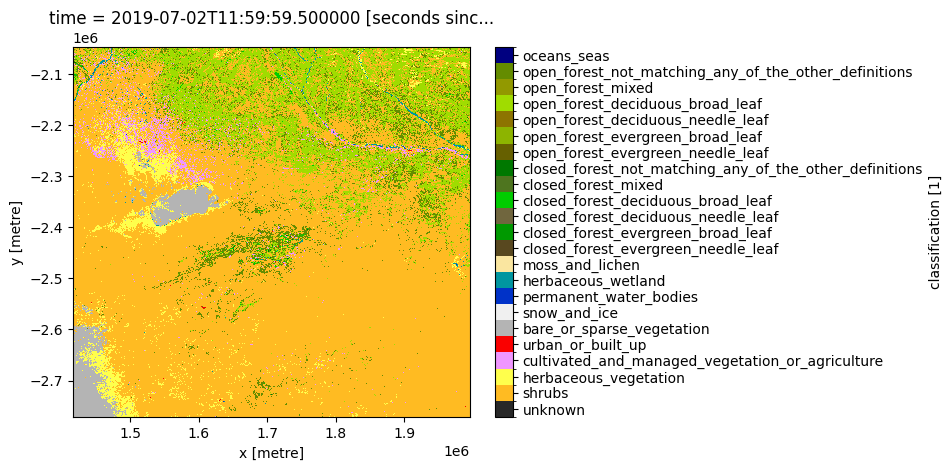

In [11]:
plot_lulc(ds_cgls.classification, product="CGLS", legend=True)

# Distance to croplands

## Visualise location of croplands

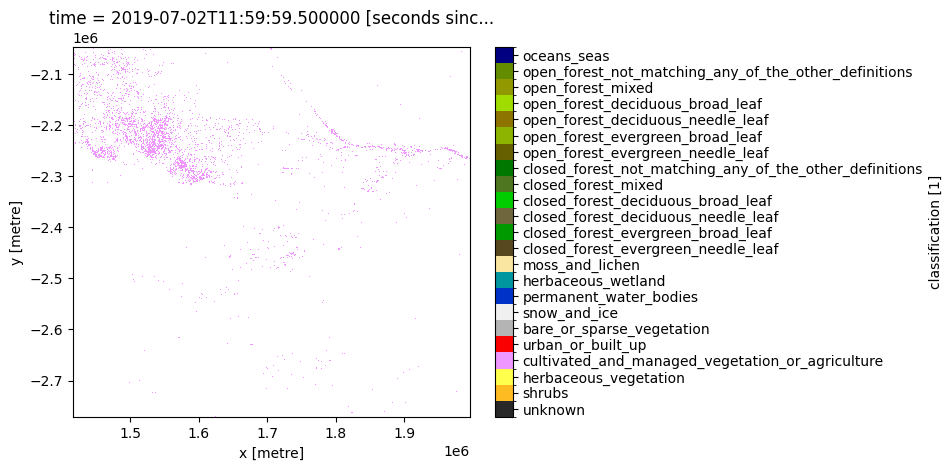

In [12]:
plot_lulc(ds_cgls.where(ds_cgls==40)[measurements], product="CGLS", legend=True)

In [13]:
cgls_crops = ds_cgls.where(ds_cgls==40)

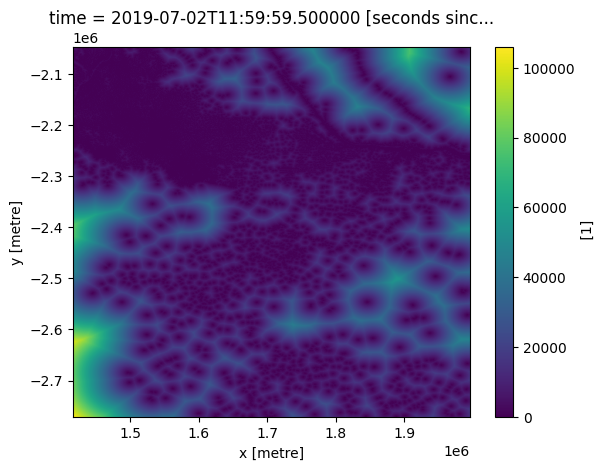

In [14]:
proximity_crops = proximity(cgls_crops.classification, distance_metric = 'EUCLIDEAN')
proximity_crops.plot()

In [15]:
crops_proximity_std = 1 - (proximity_crops/np.max(proximity_crops))

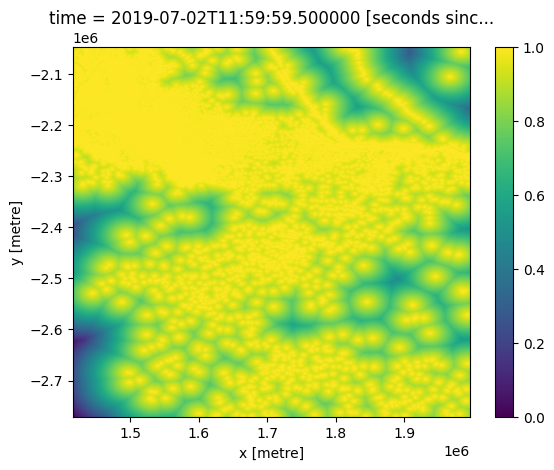

In [16]:
crops_proximity_std.plot()

# urban development

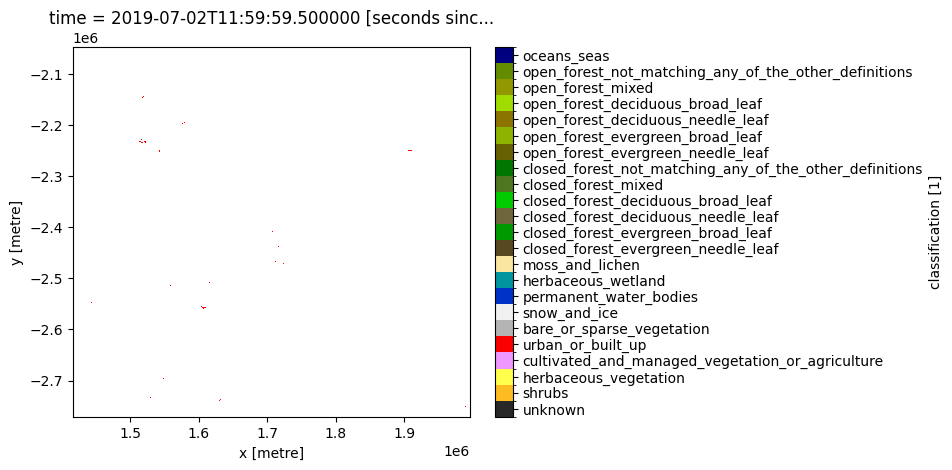

In [17]:
plot_lulc(ds_cgls.where(ds_cgls==50)[measurements], product="CGLS", legend=True)

In [18]:
cgls_urban = ds_cgls.where(ds_cgls==50)

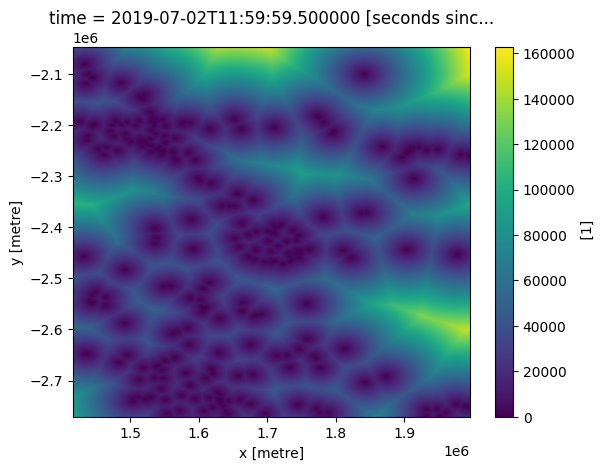

In [19]:
urban_proximity = proximity(cgls_urban.classification, distance_metric='EUCLIDEAN')
urban_proximity.plot()

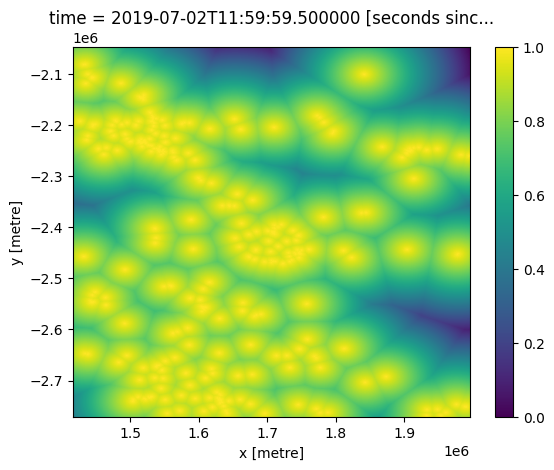

In [20]:
urban_proximity_std = 1 - (urban_proximity/np.max(urban_proximity))

urban_proximity_std.plot()

# Population density data

In [21]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"

# loading general population data

In [22]:
ds_general = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', chunks ={'x': 1000, 'y': 1000})

# running euclidean distance on population density

In [23]:
xmin = lons[0]
xmax = lons[1]
ymin = lats[0]
ymax = lats[1]

# load the data within area of interest
pop_general = ds_general.isel(band=0).sel(x=slice(
    xmin, xmax), y = slice(ymax, ymin)).coarsen(
    x=6).mean().coarsen(y=6).mean().compute().rio.reproject("EPSG:6933")

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


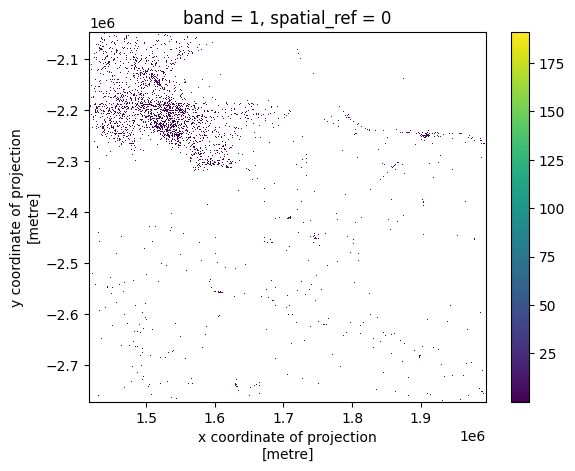

In [24]:
pop_general.plot()

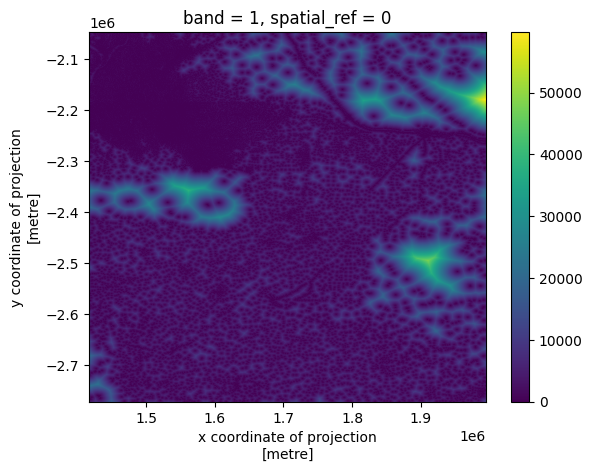

In [25]:
popn_proximity = proximity(pop_general, distance_metric='EUCLIDEAN')
popn_proximity.plot()

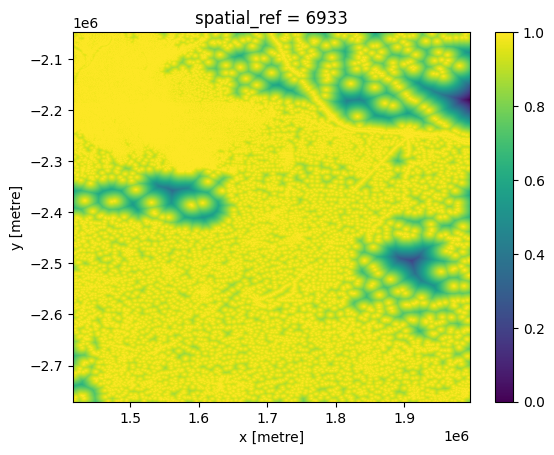

In [26]:
popn_proximity_std = 1 - (popn_proximity/np.max(popn_proximity))

popn_proximity_std = xr_reproject(src=popn_proximity_std,
                              geobox=ds_cgls.geobox,
                              resampling="average")

popn_proximity_std.plot()

# Roads - Open Street Map

In [27]:
ox.settings.cache_folder='/tmp/cache/'

In [28]:
# selected types of roads
tags = {'highway': ['motorway', 'motorway_link', 'primary', 'primary_link',
                    'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 
                    'residential', 'pedestrian']}

In [29]:
#noting the order of the bounds provided
geometries = ox.geometries_from_bbox(ymax, ymin, xmax, xmin, tags)

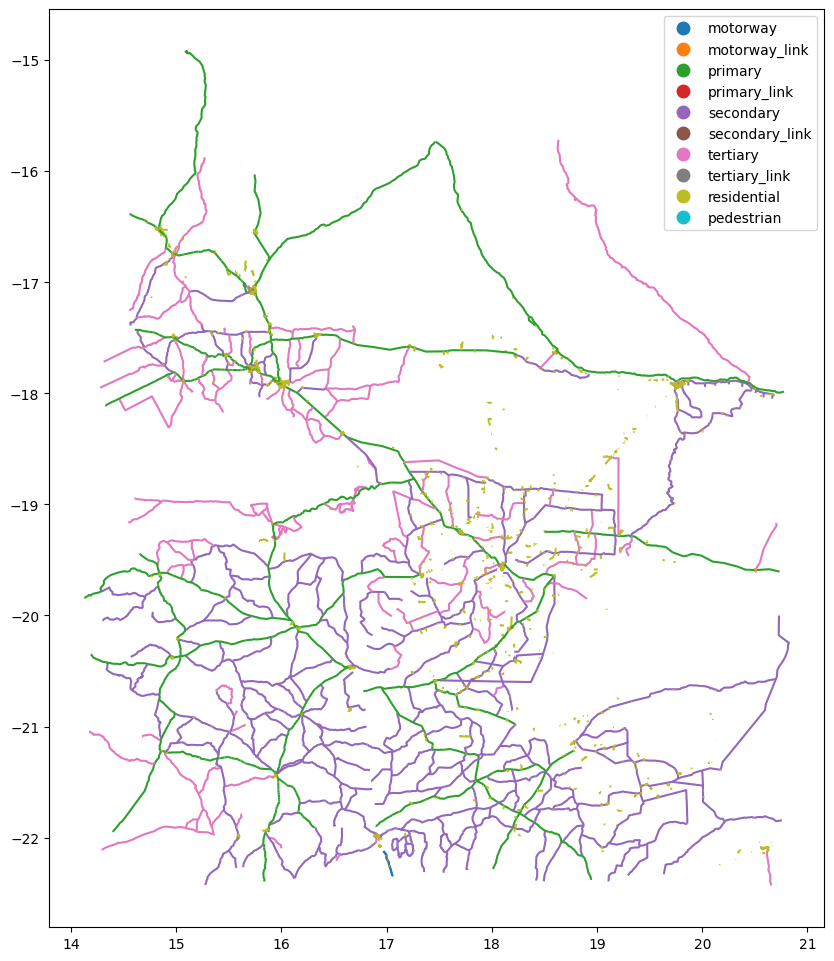

In [30]:
#visualize the geometries retrieved
geometries.plot(figsize=(10,12), cmap='tab10', column='highway', categorical=True, categories=tags['highway'], legend=True);

# running euclidean distance on roads

In [32]:
xr_roads = xr_rasterize(geometries, da=ds_cgls)

<xarray.DataArray (y: 3618, x: 2895)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 -2.047e+06 -2.048e+06 ... -2.770e+06 -2.771e+06
  * x        (x) float64 1.416e+06 1.417e+06 1.417e+06 ... 1.995e+06 1.995e+06
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [34]:
roads_proximity = proximity(xr_roads, distance_metric='EUCLIDEAN')
roads_proximity

<xarray.DataArray (y: 3618, x: 2895)>
array([[ 21400.   ,  21400.934,  21403.738, ..., 145894.75 , 146043.97 ,
        146193.3  ],
       [ 21200.   ,  21200.943,  21203.773, ..., 145761.6  , 145910.94 ,
        146060.4  ],
       [ 21000.   ,  21000.953,  21003.809, ..., 145628.56 , 145778.05 ,
        145927.66 ],
       ...,
       [ 33000.   ,  33000.605,  33002.426, ...,   4200.   ,   4400.   ,
          4600.   ],
       [ 33200.   ,  33200.6  ,  33202.41 , ...,   4200.   ,   4400.   ,
          4600.   ],
       [ 33400.   ,  33400.598,  33402.395, ...,   4200.   ,   4400.   ,
          4600.   ]], dtype=float32)
Coordinates:
  * y        (y) float64 -2.047e+06 -2.048e+06 ... -2.770e+06 -2.771e+06
  * x        (x) float64 1.416e+06 1.417e+06 1.417e+06 ... 1.995e+06 1.995e+06
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

# fuzzy buffer equation

In [35]:
roads_proximity_std = 1 - (roads_proximity/np.max(roads_proximity))

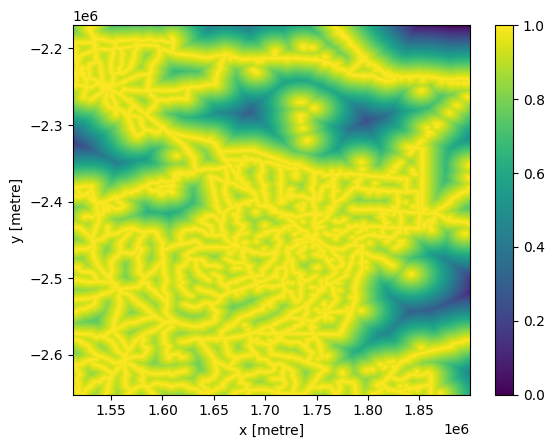

In [32]:
roads_proximity_std.plot()

# Weighted Linear Combination

$$habitat suitability = (road weighting * road fuzzy array) + (urban weighting * urban fuzzy array) + (population weighting * population fuzzy array) + (cropland weighting * cropland fuzzy array)$$

In [36]:
roads_weight=0.25
pop_weight=0.25
urban_weight=0.25
crop_weight=0.25

hp_model=(roads_proximity_std*roads_weight)+(
    urban_proximity_std*urban_weight)+(
    popn_proximity_std*pop_weight)+(
    crops_proximity_std*crop_weight)

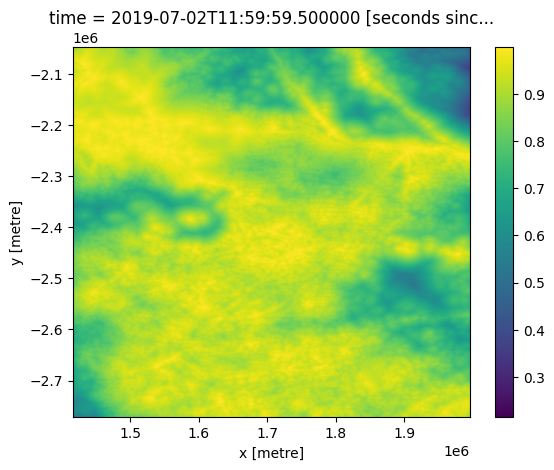

In [37]:
hp_model.plot()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [35]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [36]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-03'